In [1]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)
def sensitivity_to_mjup(mag_sens, filt, dist=10, age=100,
                        linder_models=True, file=None, **kwargs):
    """Convert sensitivity to mass limits in Jupiter masses
    
    Parameters
    ----------
    mag_sens : array-like
        Sensitivity limits in Vega magnitudes. Assumes absolute magnitudes
        unless `dist` is set to something other than 10 pc.
    filt : str
        NIRCam or MIRI filter name.

    Keyword Args
    ------------
    dist : float
        Distance in parsecs. Default is 10.
    age : float
        Age of the stellar system in Myr. Default is 100.
    linder_models : bool
        Use BEX models from Linder et al (2019) instead of AMES COND models? 
        Default is True.
    file : string
        Location and name of COND or Linder isochrone file.
    extrapolate : bool
        Extrapolate to mass limits outside of Linder model range? 
        Uses COND for upper range, and low-order polynomial fit in
        log-space for lower range. Default is True.
        
    Output
    ------
    yvals : array-like
        Mass limits in Jupiter masses corresponding to the input
        sensitivity limits in Vega magnitudes.
    """

    from webbpsf_ext.spectra import linder_table, linder_filter
    from webbpsf_ext.spectra import cond_table, cond_filter

    if linder_models:
        # Grab Linder model data
        tbl = linder_table(file=file)
        mass_data, mag_data = linder_filter(tbl, filt, age, dist=dist, **kwargs)
    else:
        # Grab COND model data
        tbl = cond_table(age=age, file=file)
        mass_data, mag_data = cond_filter(tbl, filt, dist=dist)

    # Interpolate in log space
    isort = np.argsort(mag_data)
    xv, yv = mag_data[isort], np.log10(mass_data[isort])
    xint = mag_sens
    yint = np.interp(xint, xv, yv)
    # Choose the lowest mass value brighter than the given mag limits
    yvals = np.array([np.min(yint[xint<=xv]) for xv in xint])
    yvals = 10**yvals

    return yvals

In [2]:
from astropy.io import fits
# print out the header of data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
# Define the path to the FITS file
fits_file = 'data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits'
# Open the FITS file
with fits.open(fits_file) as hdul:
    # print the data structure of the FITS file
    print("FITS file structure:")
    hdul.info()
    # Print the header of the first HDU
    for i in hdul[0].header:
        print(f"{i}: {hdul[0].header[i]}")


FITS file structure:
Filename: data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      95   (480, 480, 6)   float32   
SIMPLE: True
BITPIX: -32
NAXIS: 3
NAXIS1: 480
NAXIS2: 480
NAXIS3: 6
EXTEND: True
DRPNFILE: 32
FILE_0: jw01179005001_03107_00001_nrca2_calints.fits_INT1.fits
FILE_1: jw01179005001_03107_00001_nrca2_calints.fits_INT10.fits
FILE_2: jw01179005001_03107_00001_nrca2_calints.fits_INT11.fits
FILE_3: jw01179005001_03107_00001_nrca2_calints.fits_INT12.fits
FILE_4: jw01179005001_03107_00001_nrca2_calints.fits_INT13.fits
FILE_5: jw01179005001_03107_00001_nrca2_calints.fits_INT14.fits
FILE_6: jw01179005001_03107_00001_nrca2_calints.fits_INT15.fits
FILE_7: jw01179005001_03107_00001_nrca2_calints.fits_INT16.fits
FILE_8: jw01179005001_03107_00001_nrca2_calints.fits_INT2.fits
FILE_9: jw01179005001_03107_00001_nrca2_calints.fits_INT

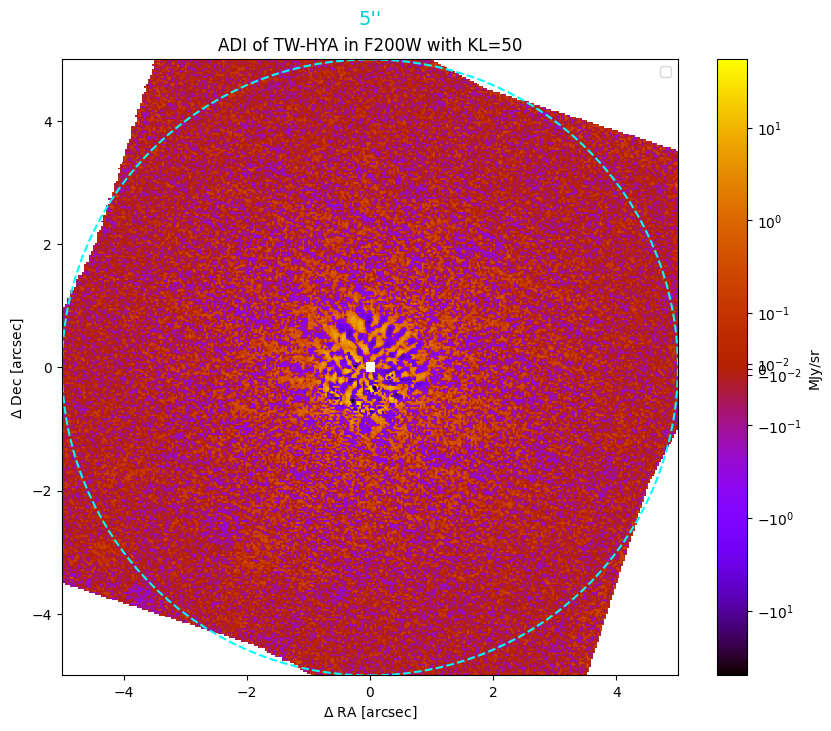

In [3]:
# Plot saved in data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
import matplotlib.pyplot as plt
from astropy.io import fits
import os
import numpy as np
import matplotlib.patches as patches # Added for the circle
from matplotlib.colors import SymLogNorm # Import SymLogNorm

# --- Zoom Configuration ---
# Set to a list like [-2, 2] to zoom, or None to disable zoom for that axis.
zoom_x_arcsec = [-5, 5]  # Example: [-5, 5]
zoom_y_arcsec = [-5, 5]  # Example: [-5, 5]
# --- End Zoom Configuration ---

# Define the path to the FITS file
fits_file = 'data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits'
# Open the FITS file
with fits.open(fits_file) as hdul:
    # Load the data from the primary HDU
    data_cube = hdul[0].data
    header = hdul[0].header

    # Determine which slice to plot (user was plotting data[1], which is index 1)
    slice_index_to_plot = 5
    image_data_to_plot = data_cube[slice_index_to_plot]

    # Get necessary info from header for title and axes
    pixscale = header.get('PIXSCALE')  # arcsec/pixel
    filter_name = header.get('FILTER', 'N/A')
    reduction_mode = header.get('MODE', 'N/A')
    target_name = header.get('TARGPROP', 'N/A')
    # KL modes are stored as KLMODEn. data_cube[0] is KLMODE0, data_cube[1] is KLMODE1, etc.
    kl_mode_key = f'KLMODE{slice_index_to_plot}'
    # Use the value from the header (e.g., KLMODE1: 2 means KL=2)
    kl_mode_value = header.get(kl_mode_key, f'Slice {slice_index_to_plot+1}') 
    bunit = header.get('BUNIT', 'Pixel Value')

    # Image dimensions for the selected slice
    ny, nx = image_data_to_plot.shape

    # Center of the image in pixels (0-indexed from PSFCENTX/Y or calculated if not present)
    center_x_pix = header.get('PSFCENTX', (nx - 1) / 2.0)
    center_y_pix = header.get('PSFCENTY', (ny - 1) / 2.0)
    
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Determine a suitable linear threshold for SymLogNorm
    linthresh = np.percentile(np.abs(image_data_to_plot[np.isfinite(image_data_to_plot) & (image_data_to_plot != 0)]), 50)
    if linthresh == 0: # Handle cases where percentile might be zero (e.g. mostly zero image)
        linthresh = 1e-5 # A small default positive value
    #linthresh = 0.03
    
    # Determine vmin and vmax for SymLogNorm to cover the data range
    data_min = np.nanmin(image_data_to_plot)
    data_max = np.nanmax(image_data_to_plot)
    #data_min = -10
    #data_max = 10

    if pixscale is not None:
        x_min_arcsec = (-0.5 - center_x_pix) * pixscale
        x_max_arcsec = (nx - 0.5 - center_x_pix) * pixscale
        y_min_arcsec = (-0.5 - center_y_pix) * pixscale # bottom for origin='lower'
        y_max_arcsec = (ny - 0.5 - center_y_pix) * pixscale # top for origin='lower'
        extent_arcsec = [x_min_arcsec, x_max_arcsec, y_min_arcsec, y_max_arcsec]

        plt.imshow(image_data_to_plot, cmap='gnuplot', origin='lower', extent=extent_arcsec, 
                   norm=SymLogNorm(linthresh=linthresh, linscale=0.5, vmin=data_min, vmax=data_max, base=10))
        plt.colorbar(label=bunit)
        
        title_str = f'{reduction_mode} of {target_name} in {filter_name} with KL={kl_mode_value}'
        plt.title(title_str)
        plt.xlabel(r'$\Delta$ RA [arcsec]')
        plt.ylabel(r'$\Delta$ Dec [arcsec]')

        reference_circle_radius = 5  # arcsec
        circle = patches.Circle((0, 0), reference_circle_radius, edgecolor='aqua', facecolor='none', linestyle='--', linewidth=1.5)
        ax.add_patch(circle)
        # add a text label for the circle
        circle_label = f'{reference_circle_radius}\'\''
        ax.text(0, reference_circle_radius + 0.5, circle_label, color='darkturquoise', fontsize=14, ha='center', va='bottom')
        ax.set_aspect('equal', adjustable='box')
        plt.legend() # Add legend to display circle label

        # Apply zoom if specified
        if zoom_x_arcsec is not None:
            ax.set_xlim(zoom_x_arcsec)
        if zoom_y_arcsec is not None:
            ax.set_ylim(zoom_y_arcsec)
    else:
        # Fallback to pixel units if pixscale is not available
        print("Warning: PIXSCALE not found in FITS header. Plotting in pixel units.")
        plt.imshow(image_data_to_plot, cmap='gnuplot', origin='lower',
                   norm=SymLogNorm(linthresh=linthresh, linscale=0.5, vmin=data_min, vmax=data_max, base=10))
        plt.colorbar(label=bunit) 
        title_str = f'{filter_name} - {reduction_mode} - KL={kl_mode_value} (Pixel Units)'
        plt.title(title_str)
        plt.xlabel('X Pixel')
        plt.ylabel('Y Pixel')
        # Note: Zoom in arcseconds is not applicable here as pixscale is missing.

    plt.show()


VOTable Version of Star Photometry Data:


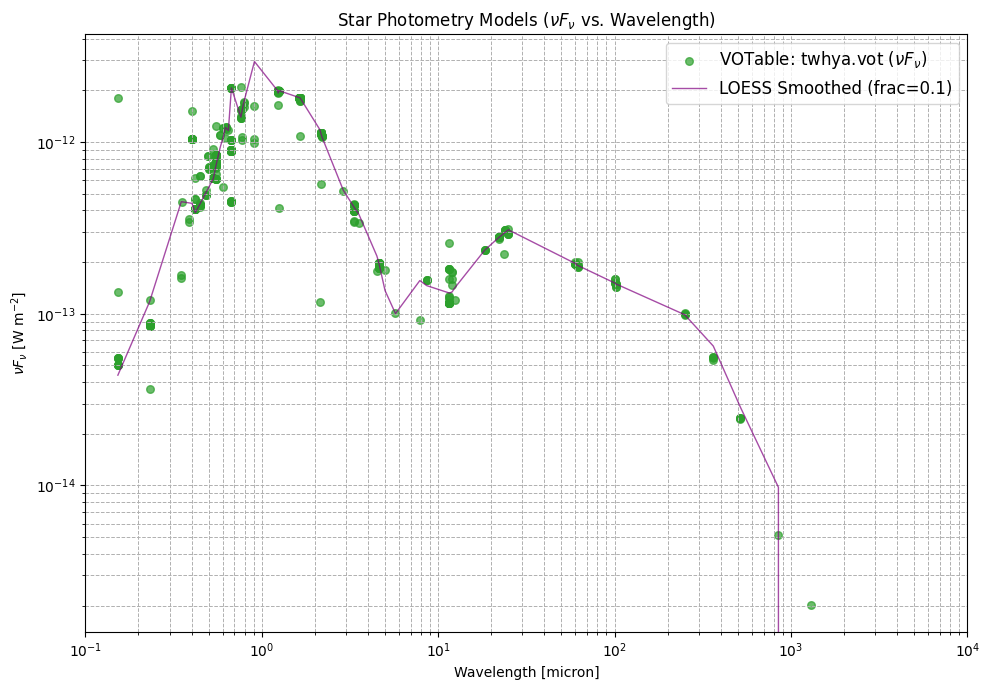

In [4]:
# Plot the Tw Hya Vega Magnitude vs Wavelength
import matplotlib.pyplot as plt
import numpy as np
import astropy
import statsmodels.api as sm

star_photometry_vot = 'twhya.vot'  # VOTable.
vega_photometry_vot = 'vega.vot'  # Vega magnitude reference.
star_spectral_type = 'M0V'  # Spectral type.

# Read in the VOTable version of the star photometry data.
star_vot = astropy.table.Table.read(star_photometry_vot)
vega_vot = astropy.table.Table.read(vega_photometry_vot)

# Convert frequency to wavelength (microns) for plotting.
star_vot["wavelength"] = (astropy.constants.c / star_vot["sed_freq"]).to(astropy.units.micron)
vega_vot["wavelength"] = (astropy.constants.c / vega_vot["sed_freq"]).to(astropy.units.micron)

print("VOTable Version of Star Photometry Data:")
star_vot.to_pandas()  # For an easier to read output.
vega_vot.to_pandas()  # For an easier to read output.

# Constants
c = 299792458.0  # Speed of light in m/s
Jy_to_Wm2Hz = 1e-26  # Conversion factor for Jansky to W/m^-2/Hz^-1
micron_to_m = 1e-6   # Conversion factor for micron to m

# Extract data from your star_vot
star_wavelength_microns = star_vot["wavelength"]
star_sed_flux_jansky = star_vot["sed_flux"]
star_sed_flux_jansky_sorted = np.sort(star_sed_flux_jansky)

# 1. Convert wavelength from microns to meters
star_wavelength_m = star_wavelength_microns * micron_to_m

# 2. Calculate frequency (nu) in Hz
star_frequency_hz = c / star_wavelength_m

# 3. Convert flux density F_nu from Jansky to W/m^2/Hz
star_sed_flux_Wm2Hz = star_sed_flux_jansky * Jy_to_Wm2Hz

# 4. Calculate nu * F_nu in W/m^2
star_nu_F_nu_Wm2 = star_frequency_hz * star_sed_flux_Wm2Hz

# 5. Smoothing the data using LOESS (Locally Estimated Scatterplot Smoothing)
# --- Sort data by wavelength for LOESS and cleaner plotting (though LOESS sorts x) ---
star_sort_indices = np.argsort(star_wavelength_microns)
star_wavelength_microns_sorted = star_wavelength_microns[star_sort_indices]
star_nu_F_nu_Wm2_sorted = star_nu_F_nu_Wm2[star_sort_indices]

# --- Apply LOESS smoothing ---
# The 'frac' parameter controls the smoothness.
# It's the fraction of data used for each local regression.
# Adjust this value (e.g., 0.1 to 0.5) to change smoothness.
frac_value = 0.1
smoothed_star_nu_F_nu_Wm2 = sm.nonparametric.lowess(star_nu_F_nu_Wm2_sorted, star_wavelength_microns_sorted, frac=frac_value)

# --- Returns an array of (x_sorted, y_smoothed) ---
smoothed_x = smoothed_star_nu_F_nu_Wm2[:, 0]
smoothed_y = smoothed_star_nu_F_nu_Wm2[:, 1]

# Final Plotting
# --- Figure Configuration ---
plt.figure(figsize=(10, 7)) # Slightly larger for better readability

# Plot the star photometry data
plt.scatter(
    star_wavelength_microns, # X-axis remains wavelength in microns
    star_nu_F_nu_Wm2,
    label=r"VOTable: twhya.vot ($\nu F_{\nu}$)", # Use LaTeX for nu F_nu
    color="C2", # Changed color for distinction if you plot both
    s=30,       # Marker size
    alpha=0.7   # Marker transparency
)

# Plot the LOESS smoothed curve
plt.plot(
    smoothed_x,
    smoothed_y,
    color='purple', # A distinct color for the smooth line
    linewidth=1,
    label=f'LOESS Smoothed (frac={frac_value})',
    alpha=0.7   # Marker transparency
)

plt.xlabel("Wavelength [micron]")
plt.ylabel(r"$\nu F_{\nu}$ [W m$^{-2}$]") # LaTeX for units
plt.legend(fontsize=12)

plt.xscale("log")
plt.yscale("log")

plt.xlim(0.1, 10**4)
plt.grid(True, linestyle="--", linewidth=0.7, which="both") # 'which="both"' is good for log scales
plt.title(r"Star Photometry Models ($\nu F_{\nu}$ vs. Wavelength)")

plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

Vega magnitude at 1.0 microns: 9.64


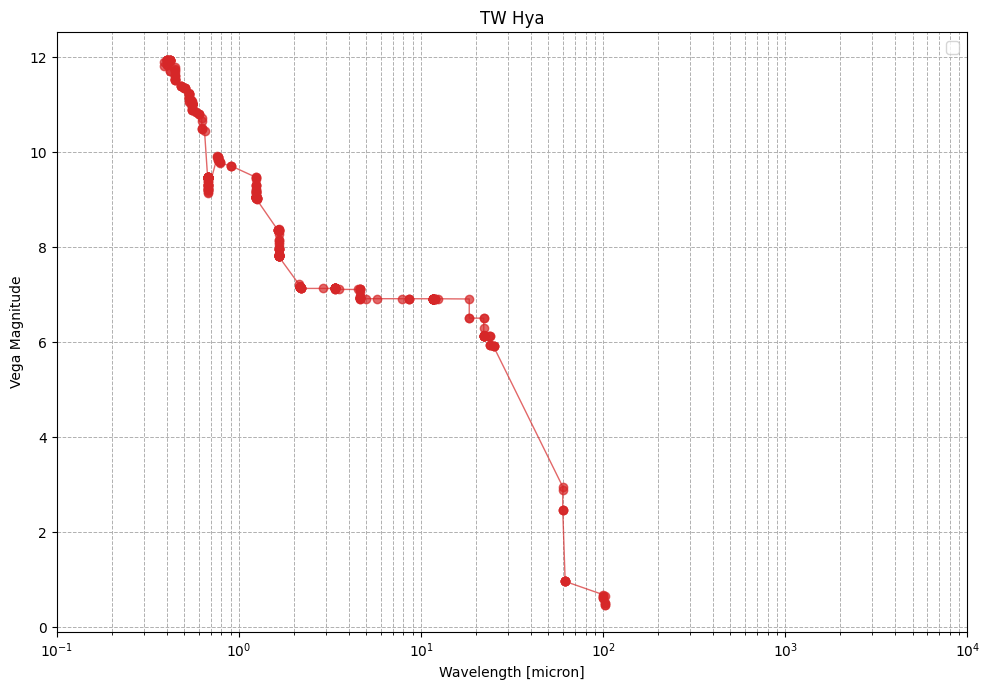

In [5]:
# 6. Calculate Vega magnitude vs wavelength 
# --- Extract Vega data ---
vega_wavelength_microns = vega_vot["wavelength"]
vega_sed_flux_jansky = vega_vot["sed_flux"]
vega_sort_indices = np.argsort(vega_wavelength_microns)
vega_wavelength_microns_sorted = vega_wavelength_microns[vega_sort_indices]
vega_sed_flux_jansky_sorted = vega_sed_flux_jansky[vega_sort_indices]

# --- Calculate smooth curve for Vega ---
smoothed_vega_flux = sm.nonparametric.lowess(vega_sed_flux_jansky_sorted, vega_wavelength_microns_sorted, frac=frac_value)
smoothed_star_flux = sm.nonparametric.lowess(star_sed_flux_jansky_sorted, star_wavelength_microns_sorted, frac=frac_value)

# --- Interpolate Vega flux at star wavelengths and calculate Vega magnitudes ---
from scipy.interpolate import interp1d
vega_flux_interp = interp1d(vega_wavelength_microns_sorted, smoothed_vega_flux[:, 1], bounds_error=False, fill_value="extrapolate")
vega_flux_at_star_wavelengths = vega_flux_interp(star_wavelength_microns_sorted)

# --- Calculate Vega magnitudes at star wavelengths ---
vega_magnitudes = -2.5 * np.log10(star_sed_flux_jansky_sorted / vega_flux_at_star_wavelengths)

# --- Interpret the Vega magnitude data ---
from scipy.interpolate import interp1d
star_flux_vega_mag_interp = interp1d(star_wavelength_microns_sorted, vega_magnitudes, bounds_error=False, fill_value="extrapolate")

# Test the interpolation at a specific wavelength
test_wavelength = 1.0  # Example wavelength in microns
vega_mag_at_test_wavelength = star_flux_vega_mag_interp(test_wavelength)
print(f"Vega magnitude at {test_wavelength} microns: {vega_mag_at_test_wavelength:.2f}")

# --- Plotting the Vega magnitude vs wavelength ---
plt.figure(figsize=(10, 7)) # Slightly larger for better readability
# Plot the Vega magnitude vs wavelength
plt.plot(
    star_wavelength_microns_sorted,
    vega_magnitudes,
    color="C3", # Distinct color for Vega magnitude
    linewidth=1,
    marker='o', # Use markers for visibility
    alpha=0.7   # Marker transparency
)
plt.xlabel("Wavelength [micron]")
plt.ylabel("Vega Magnitude")
plt.legend(fontsize=12)
plt.xscale("log")
plt.xlim(0.1, 10**4)
plt.grid(True, linestyle="--", linewidth=0.7, which="both") # 'which="both"' is good for log scales
plt.title("TW Hya")
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

(184,)


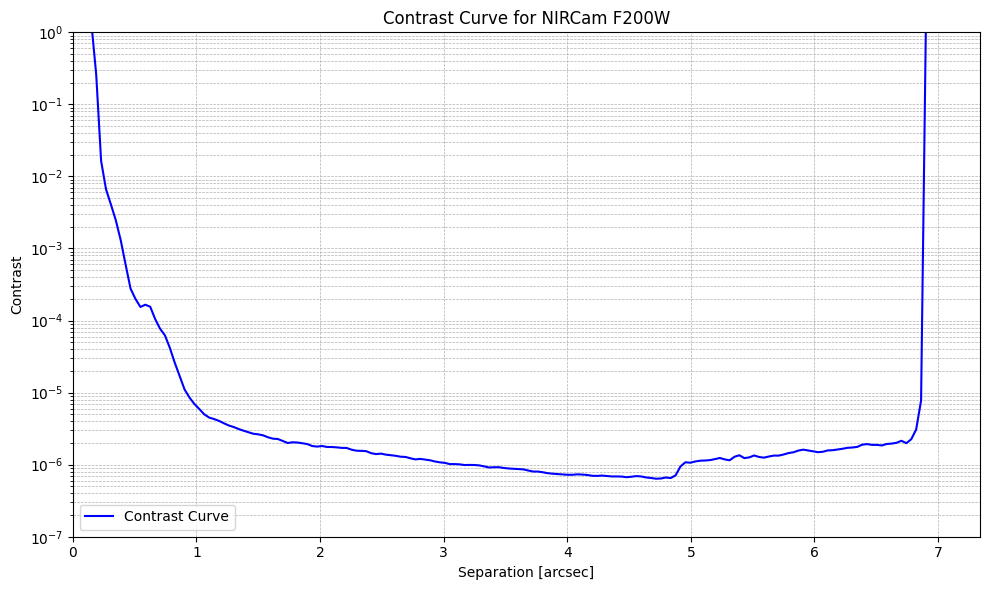

In [6]:
contrast_curve_file = 'data_nircam_twhya/calcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_maskcons.npy'
separations_arcsec_file = 'data_nircam_twhya/calcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_seps.npy'
# Load the contrast curve data
slide_index = 5  # Example index to load data for a specific KL mode
contrast_data = np.load(contrast_curve_file)[slide_index]
separations_arcsec = np.load(separations_arcsec_file)[slide_index]

print(np.shape(contrast_data))
#plot the contrast curve
plt.figure(figsize=(10, 6))
plt.plot(separations_arcsec, contrast_data, label='Contrast Curve', color='blue')
plt.xlabel('Separation [arcsec]')
plt.ylabel('Contrast')
plt.title('Contrast Curve for NIRCam F200W')
plt.yscale('log')
plt.xlim(0, np.nanmax(separations_arcsec))
plt.ylim(1e-7, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Valid Separations: 4.9 arcsec
Successfully opened FITS file: data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
Data cube has 6 slices.
Slice 0: KLMODE0 = 1
Slice 1: KLMODE1 = 2
Slice 2: KLMODE2 = 5
Slice 3: KLMODE3 = 10
Slice 4: KLMODE4 = 20
Slice 5: KLMODE5 = 50
Found slice 5 corresponding to KL=50.
Using Star Magnitude (F200W): 7.37768204649816
Using PIXSCALE: 0.03068494 arcsec/pixel
Loaded contrast data for KL=50 with 119 valid points.
Calculating mass limits for age 5 Myr...
Calculating mass limits for age 10 Myr...


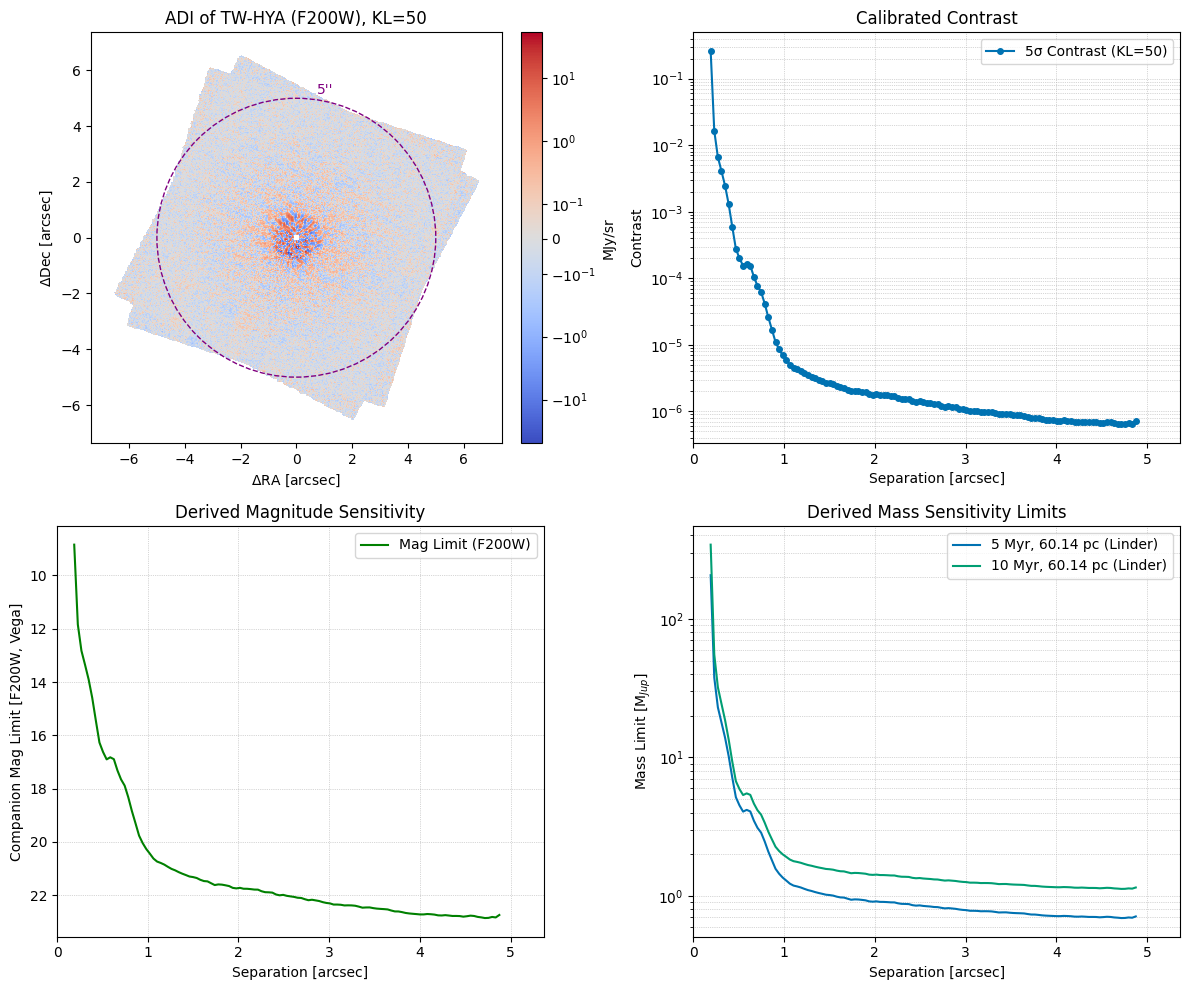

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
import matplotlib.patches as patches
from matplotlib.colors import SymLogNorm
import webbpsf_ext

# Define the path to the FITS file, contrast curve file, and separations file
fits_file = 'data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits'
contrast_curve_file = 'data_nircam_twhya/calcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_maskcons.npy'
separations_arcsec_file = 'data_nircam_twhya/calcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_seps.npy'

# TW Hya parameters
tw_hya_distance_pc = 60.14  # pc
valid_separation = 4.9 # arcsec
print(f"Valid Separations: {valid_separation} arcsec")
planet_ages_myr = [5, 10]  # Myr
target_filter = 'F200W' # Filter used

selected_kl_value = 50
image_data_klip = None
header_klip = None
kl_slice_index = -1

try:
    with fits.open(fits_file) as hdul:
        print(f"Successfully opened FITS file: {fits_file}")
        data_cube = hdul[0].data
        header_klip = hdul[0].header
        
        if data_cube.ndim == 3: # Check if it's a data cube
            num_slices = data_cube.shape[0]
            print(f"Data cube has {num_slices} slices.")
            for i in range(num_slices):
                kl_mode_key = f'KLMODE{i}'
                kl_modes_for_slice = header_klip.get(kl_mode_key)
                if kl_modes_for_slice is not None:
                    print(f"Slice {i}: {kl_mode_key} = {kl_modes_for_slice}")
                    if int(kl_modes_for_slice) == selected_kl_value:
                        image_data_klip = data_cube[i]
                        kl_slice_index = i
                        print(f"Found slice {i} corresponding to KL={selected_kl_value}.")
                        break
                else:
                    print(f"Slice {i}: {kl_mode_key} not found in header.")
            
            if image_data_klip is None:
                print(f"Error: Could not find a slice processed with KL={selected_kl_value}.")
                # Fallback to the first slice if not found
                image_data_klip = data_cube[0]
                kl_slice_index = 0
                print(f"Using fallback slice 0 for KL={selected_kl_value}.")

        elif data_cube.ndim == 2: # Check if it's a single 2D image
            print("FITS file contains a single 2D image.")
            # This case might not be for KL-modes-all, but handle it.
            image_data_klip = data_cube
            try: 
                selected_kl_value = header_klip.get('KLMODES', selected_kl_value)
                print(f"Using KL modes from header: {selected_kl_value}")
            except KeyError:
                print(f"Warning: KLMODES not found in header.")
        
        else:
            raise ValueError(f"Unexpected data shape: {data_cube.shape}. Expected 2D or 3D data.")

        if image_data_klip is None:
            raise ValueError(f"Could not load image data for KL={selected_kl_value} or as a fallback.")

        # Extract metadata
        wavelength_microns = header_klip.get('CWAVEL')
        star_mag_f200w = star_flux_vega_mag_interp(wavelength_microns)  # Example wavelength in microns, using the interpolated Vega magnitude
        print(f"Using Star Magnitude (F200W): {star_mag_f200w}")
        pixscale = header_klip.get('PIXSCALE')  # arcsec/pixel
        if pixscale is None:
            pixscale = 0.031
            print(f"Warning: PIXSCALE not found. Using default {pixscale} arcsec/pixel.")
        print(f"Using PIXSCALE: {pixscale} arcsec/pixel")
        bunit = header_klip.get('BUNIT', 'Data Units')
        reduction_mode = header_klip.get('MODE', 'ADI') # e.g. ADI, RDI
        target_name = header_klip.get('TARGPROP', 'TW Hya')
        ny, nx = image_data_klip.shape
        psfcentx = header_klip.get('PSFCENTX', (nx - 1) / 2.0)
        psfcenty = header_klip.get('PSFCENTY', (ny - 1) / 2.0)
        
        # Load the contrast curve data
        contrast_data = np.load(contrast_curve_file)[kl_slice_index]
        separations_arcsec = np.load(separations_arcsec_file)[kl_slice_index]
        
        # Filter out zero/negative contrasts or separations if any before log
        valid_indices = (contrast_data < 1) & (contrast_data > 0) & (separations_arcsec > 0) & (separations_arcsec < valid_separation)
        separations_arcsec = separations_arcsec[valid_indices]
        contrast_data = contrast_data[valid_indices]
        print(f"Loaded contrast data for KL={selected_kl_value} with {len(separations_arcsec)} valid points.")

        # Convert contrast to delta magnitudes and then companion magnitude limits
        delta_mag = -2.5 * np.log10(contrast_data)
        companion_mag_limits = star_mag_f200w + delta_mag

        # Calculate mass limits using the sensitivity_to_mjup function
        mass_limits_mjup_collection =[]
        for planet_age_myr in planet_ages_myr:
            print(f"Calculating mass limits for age {planet_age_myr} Myr...")
            mass_limits_mjup_collection.append(sensitivity_to_mjup(
                mag_sens=companion_mag_limits,
                filt=target_filter,
                dist=tw_hya_distance_pc,
                age=planet_age_myr,
                linder_models=True # Assuming Linder models as per previous examples
            ))

        # Plotting results
        plt.style.use('seaborn-v0_8-colorblind') # Using a nice style
        fig = plt.figure(figsize=(12, 10))
        
        # Plot 1: KLIP-processed 2D image
        ax1 = fig.add_subplot(2, 2, 1)
        img_display_data = image_data_klip.copy()
        # Determine a suitable linear threshold for SymLogNorm
        valid_img_data = img_display_data[np.isfinite(img_display_data) & (img_display_data != 0)]
        if len(valid_img_data) > 0:
            # choose a linear threshold based on the 50th percentile of the absolute values
            linthresh = np.percentile(np.abs(valid_img_data), 50)
            # convert to the closest 10th power
            linthresh = 10**np.round(np.log10(linthresh))
            if linthresh == 0: linthresh = 1e-5 
            data_min = np.nanmin(img_display_data)
            data_max = np.nanmax(img_display_data)
        else:
            linthresh = 1e-5
            data_min = -1
            data_max = 1
        
        im = ax1.imshow(img_display_data, cmap='coolwarm', origin='lower', 
                        extent=[(-psfcentx - 0.5) * pixscale, (nx - psfcentx - 0.5) * pixscale,
                                (-psfcenty - 0.5) * pixscale, (ny - psfcenty - 0.5) * pixscale],
                        norm=SymLogNorm(linthresh=linthresh, linscale=0.5, vmin=data_min, vmax=data_max, base=10))
        cb = plt.colorbar(im, ax=ax1, label=bunit, fraction=0.046, pad=0.04)
        ax1.set_title(f'{reduction_mode} of {target_name} ({target_filter}), KL={selected_kl_value}')
        ax1.set_xlabel(r'$\Delta$RA [arcsec]')
        ax1.set_ylabel(r'$\Delta$Dec [arcsec]')
        ax1.set_aspect('equal', adjustable='box')
        # Add a reference circle (e.g. 5 arcsec)
        circle = patches.Circle((0, 0), 5, edgecolor='purple', facecolor='none', linestyle='--', linewidth=1)
        ax1.add_patch(circle)
        ax1.text(1.05, 5.05, "5''", color='purple', ha='center', va='bottom')

        # Plot 2: Radial Contrast Profile
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.semilogy(separations_arcsec, contrast_data, 'o-', markersize=4, label=f'5σ Contrast (KL={selected_kl_value})')
        ax2.set_xlabel('Separation [arcsec]')
        ax2.set_xlim(0, np.max(separations_arcsec) * 1.1)
        ax2.set_ylabel('Contrast')
        ax2.set_title('Calibrated Contrast')
        ax2.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax2.legend()

        # Plot 3: Companion Magnitude Limits
        ax3 = fig.add_subplot(2, 2, 3)
        ax3.plot(separations_arcsec, companion_mag_limits, 's-', markersize=0, color='green', label=f'Mag Limit ({target_filter})')
        ax3.set_xlabel('Separation [arcsec]')
        ax3.set_xlim(0, np.max(separations_arcsec) * 1.1)
        ax3.set_ylabel(f'Companion Mag Limit [{target_filter}, Vega]')
        ax3.set_title('Derived Magnitude Sensitivity')
        ax3.invert_yaxis() # Fainter magnitudes are larger numbers
        ax3.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax3.legend()

        # Plot 4: Mass Sensitivity Limits
        ax4 = fig.add_subplot(2, 2, 4)
        for i, planet_age_myr in enumerate(planet_ages_myr):
            ax4.semilogy(separations_arcsec, mass_limits_mjup_collection[i], '^-', markersize=0, label=f'{planet_age_myr} Myr, {tw_hya_distance_pc} pc (Linder)')
        ax4.set_xlabel('Separation [arcsec]')
        ax4.set_xlim(0, np.max(separations_arcsec) * 1.1)
        ax4.set_ylabel(r'Mass Limit [M$_{Jup}$]')
        ax4.set_title('Derived Mass Sensitivity Limits')
        ax4.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax4.legend()

        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print(f"Error: FITS file not found at {fits_file}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()

Valid Separations: 4.9 arcsec
Successfully opened FITS file: data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits
Data cube has 6 slices.
Slice 0: KLMODE0 = 1
Slice 1: KLMODE1 = 2
Slice 2: KLMODE2 = 5
Slice 3: KLMODE3 = 10
Slice 4: KLMODE4 = 20
Slice 5: KLMODE5 = 50
Found slice 5 corresponding to KL=50.
Using Star Magnitude (F200W): 7.37768204649816
Using PIXSCALE: 0.03068494 arcsec/pixel
Loaded contrast data for KL=50 with 119 valid points.
Calculating mass limits for age 5 Myr...
Calculating mass limits for age 10 Myr...


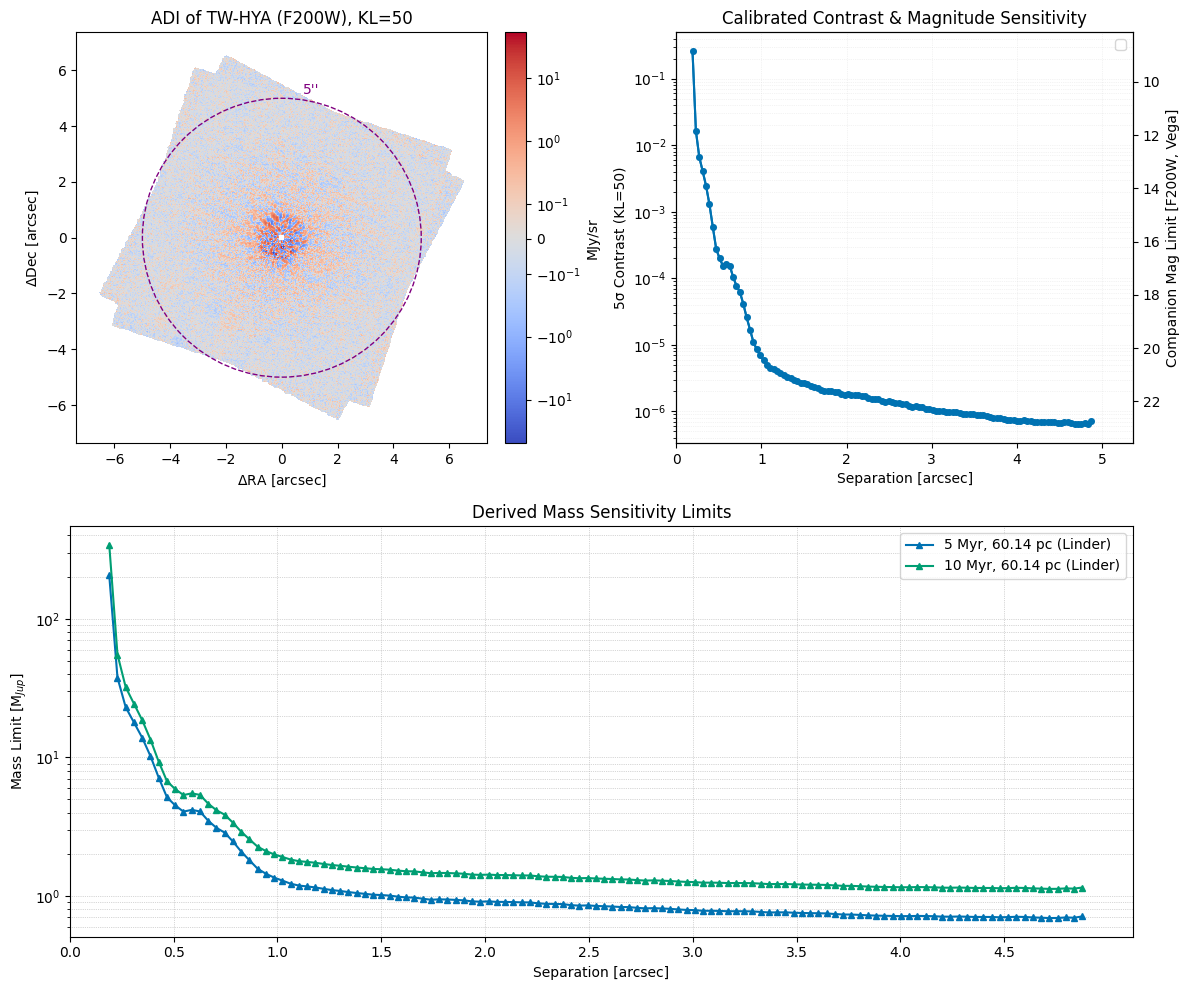

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
import matplotlib.patches as patches
from matplotlib.colors import SymLogNorm
import webbpsf_ext

# Define the path to the FITS file, contrast curve file, and separations file
fits_file = 'data_nircam_twhya/klipsub/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all.fits'
contrast_curve_file = 'data_nircam_twhya/calcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_maskcons.npy'
separations_arcsec_file = 'data_nircam_twhya/calcon/ADI_NANNU1_NSUBS1_JWST_NIRCAM_NRCA2_F200W_MASKRND_MASK335R_SUB320A335R-KLmodes-all_cal_seps.npy'

# TW Hya parameters
tw_hya_distance_pc = 60.14  # pc
valid_separation = 4.9 # arcsec
print(f"Valid Separations: {valid_separation} arcsec")
planet_ages_myr = [5, 10]  # Myr
target_filter = 'F200W' # Filter used

selected_kl_value = 50
image_data_klip = None
header_klip = None
kl_slice_index = -1

try:
    with fits.open(fits_file) as hdul:
        print(f"Successfully opened FITS file: {fits_file}")
        data_cube = hdul[0].data
        header_klip = hdul[0].header
        
        if data_cube.ndim == 3: # Check if it's a data cube
            num_slices = data_cube.shape[0]
            print(f"Data cube has {num_slices} slices.")
            for i in range(num_slices):
                kl_mode_key = f'KLMODE{i}'
                kl_modes_for_slice = header_klip.get(kl_mode_key)
                if kl_modes_for_slice is not None:
                    print(f"Slice {i}: {kl_mode_key} = {kl_modes_for_slice}")
                    if int(kl_modes_for_slice) == selected_kl_value:
                        image_data_klip = data_cube[i]
                        kl_slice_index = i
                        print(f"Found slice {i} corresponding to KL={selected_kl_value}.")
                        break
                else:
                    print(f"Slice {i}: {kl_mode_key} not found in header.")
            
            if image_data_klip is None:
                print(f"Error: Could not find a slice processed with KL={selected_kl_value}.")
                # Fallback to the first slice if not found
                image_data_klip = data_cube[0]
                kl_slice_index = 0
                print(f"Using fallback slice 0 for KL={selected_kl_value}.")

        elif data_cube.ndim == 2: # Check if it's a single 2D image
            print("FITS file contains a single 2D image.")
            # This case might not be for KL-modes-all, but handle it.
            image_data_klip = data_cube
            try: 
                selected_kl_value = header_klip.get('KLMODES', selected_kl_value)
                print(f"Using KL modes from header: {selected_kl_value}")
            except KeyError:
                print(f"Warning: KLMODES not found in header.")
        
        else:
            raise ValueError(f"Unexpected data shape: {data_cube.shape}. Expected 2D or 3D data.")

        if image_data_klip is None:
            raise ValueError(f"Could not load image data for KL={selected_kl_value} or as a fallback.")

        # Extract metadata
        wavelength_microns = header_klip.get('CWAVEL')
        star_mag_f200w = star_flux_vega_mag_interp(wavelength_microns)  # Example wavelength in microns, using the interpolated Vega magnitude
        print(f"Using Star Magnitude (F200W): {star_mag_f200w}")
        pixscale = header_klip.get('PIXSCALE')  # arcsec/pixel
        if pixscale is None:
            pixscale = 0.031
            print(f"Warning: PIXSCALE not found. Using default {pixscale} arcsec/pixel.")
        print(f"Using PIXSCALE: {pixscale} arcsec/pixel")
        bunit = header_klip.get('BUNIT', 'Data Units')
        reduction_mode = header_klip.get('MODE', 'ADI') # e.g. ADI, RDI
        target_name = header_klip.get('TARGPROP', 'TW Hya')
        ny, nx = image_data_klip.shape
        psfcentx = header_klip.get('PSFCENTX', (nx - 1) / 2.0)
        psfcenty = header_klip.get('PSFCENTY', (ny - 1) / 2.0)
        
        # Load the contrast curve data
        contrast_data = np.load(contrast_curve_file)[kl_slice_index]
        separations_arcsec = np.load(separations_arcsec_file)[kl_slice_index]
        
        # Filter out zero/negative contrasts or separations if any before log
        valid_indices = (contrast_data < 1) & (contrast_data > 0) & (separations_arcsec > 0) & (separations_arcsec < valid_separation)
        separations_arcsec = separations_arcsec[valid_indices]
        contrast_data = contrast_data[valid_indices]
        print(f"Loaded contrast data for KL={selected_kl_value} with {len(separations_arcsec)} valid points.")

        # Convert contrast to delta magnitudes and then companion magnitude limits
        delta_mag = -2.5 * np.log10(contrast_data)
        companion_mag_limits = star_mag_f200w + delta_mag

        # Calculate mass limits using the sensitivity_to_mjup function
        mass_limits_mjup_collection =[]
        for planet_age_myr in planet_ages_myr:
            print(f"Calculating mass limits for age {planet_age_myr} Myr...")
            mass_limits_mjup_collection.append(sensitivity_to_mjup(
                mag_sens=companion_mag_limits,
                filt=target_filter,
                dist=tw_hya_distance_pc,
                age=planet_age_myr,
                linder_models=True # Assuming Linder models as per previous examples
            ))

        # Plotting results with modified layout
        plt.style.use('seaborn-v0_8-colorblind') # Using a nice style
        fig = plt.figure(figsize=(12, 10))
        
        # Create a grid layout: 2 rows, 2 columns
        # Top row: left = image, right = contrast+magnitude (dual y-axis)
        # Bottom row: spans full width for mass sensitivity
        
        # Plot 1: KLIP-processed 2D image (top left)
        ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
        img_display_data = image_data_klip.copy()
        # Determine a suitable linear threshold for SymLogNorm
        valid_img_data = img_display_data[np.isfinite(img_display_data) & (img_display_data != 0)]
        if len(valid_img_data) > 0:
            # choose a linear threshold based on the 50th percentile of the absolute values
            linthresh = np.percentile(np.abs(valid_img_data), 50)
            # convert to the closest 10th power
            linthresh = 10**np.round(np.log10(linthresh))
            if linthresh == 0: linthresh = 1e-5 
            data_min = np.nanmin(img_display_data)
            data_max = np.nanmax(img_display_data)
        else:
            linthresh = 1e-5
            data_min = -1
            data_max = 1
        
        im = ax1.imshow(img_display_data, cmap='coolwarm', origin='lower', 
                        extent=[(-psfcentx - 0.5) * pixscale, (nx - psfcentx - 0.5) * pixscale,
                                (-psfcenty - 0.5) * pixscale, (ny - psfcenty - 0.5) * pixscale],
                        norm=SymLogNorm(linthresh=linthresh, linscale=0.5, vmin=data_min, vmax=data_max, base=10))
        cb = plt.colorbar(im, ax=ax1, label=bunit, fraction=0.046, pad=0.04)
        ax1.set_title(f'{reduction_mode} of {target_name} ({target_filter}), KL={selected_kl_value}')
        ax1.set_xlabel(r'$\Delta$RA [arcsec]')
        ax1.set_ylabel(r'$\Delta$Dec [arcsec]')
        ax1.set_aspect('equal', adjustable='box')
        # Add a reference circle (e.g. 5 arcsec)
        circle = patches.Circle((0, 0), 5, edgecolor='purple', facecolor='none', linestyle='--', linewidth=1)
        ax1.add_patch(circle)
        ax1.text(1.05, 5.05, "5''", color='purple', ha='center', va='bottom')

        # Plot 2: Combined Contrast and Magnitude with dual y-axes (top right)
        ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
        
        # Left y-axis for contrast
        color1 = 'tab:blue'
        ax2.set_xlabel('Separation [arcsec]')
        ax2.set_ylabel(f'5σ Contrast (KL={selected_kl_value})')
        line1 = ax2.semilogy(separations_arcsec, contrast_data, 'o-', markersize=4)
        ax2.tick_params(axis='y')
        ax2.set_xlim(0, np.max(separations_arcsec) * 1.1)
        ax2.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.3)
        
        # Right y-axis for magnitude
        ax2_twin = ax2.twinx()
        color2 = 'tab:green'
        ax2_twin.set_ylabel(f'Companion Mag Limit [{target_filter}, Vega]')
        line2 = ax2_twin.plot(separations_arcsec, companion_mag_limits, 's-', markersize=3)
        ax2_twin.tick_params(axis='y')
        ax2_twin.invert_yaxis() # Fainter magnitudes are larger numbers
        
        # Add combined legend
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels, loc='upper right')
        ax2.set_title('Calibrated Contrast & Magnitude Sensitivity')

        # Plot 3: Mass Sensitivity Limits (bottom, spanning full width)
        ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)
        for i, planet_age_myr in enumerate(planet_ages_myr):
            ax3.semilogy(separations_arcsec, mass_limits_mjup_collection[i], '^-', markersize=4, label=f'{planet_age_myr} Myr, {tw_hya_distance_pc} pc (Linder)')
        ax3.set_xticks(np.arange(0, np.max(separations_arcsec), 0.5))
        ax3.set_xlabel('Separation [arcsec]')
        ax3.set_xlim(0, np.max(separations_arcsec) * 1.05)
        ax3.set_ylabel(r'Mass Limit [M$_{Jup}$]')
        ax3.set_title('Derived Mass Sensitivity Limits')
        ax3.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax3.legend()

        plt.tight_layout()
        plt.show()

except FileNotFoundError:
    print(f"Error: FITS file not found at {fits_file}")
except ValueError as ve:
    print(f"ValueError: {ve}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()